## Predicting Forex Charts
This algorithm works by using neural networking algorithm known as NEAT. **"NEAT"** stands for **"Neural Networks through Augmented Topologies"**

Explanation of how the algorithm works: https://www.cs.ucf.edu/~kstanley/neat.html

# Retrieving / Downloading Forex Charts

### Download Data
To save the data of the chart, we'll use yfinance to download and save the data as a csv file. This piece of code saves the data as a .csv file.

```py
# Imports
from matplotlib import ticker
import yfinance as yf

# Variables
ticker_name: str = "JPY=X" # "JPY=X"


# Download ticker data
ticker_data = yf.download(
    tickers=ticker_name, # Set ticker as variable
    period="max", # Get as much data as possible
)

ticker_data.to_csv(f"./../assets/{ticker_name}.csv") # Save dataframe as a csv file

ticker_data # Display Ticker Data
```

## Retrieving Data
To retrieve the data, we'll use requests pull the file from the github repository.

In [70]:
import pandas as pd
import http.client as client # Need to read text file

# Use links to store data
assets_path = "https://github.com/royce-mathew/data/raw/master"

# Pandas automatically makes the request
ticker_data = pd.read_csv(f"{assets_path}/JPY=X.csv", index_col=0)
# Test data


# TO DO: Import config with requests too
ticker_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0
...,...,...,...,...,...,...
2022-11-07,146.841003,147.552994,146.113998,146.841003,146.841003,0
2022-11-08,146.623993,146.927002,145.313004,146.623993,146.623993,0
2022-11-09,145.294998,146.557999,145.218994,145.294998,145.294998,0


<AxesSubplot: xlabel='Date'>

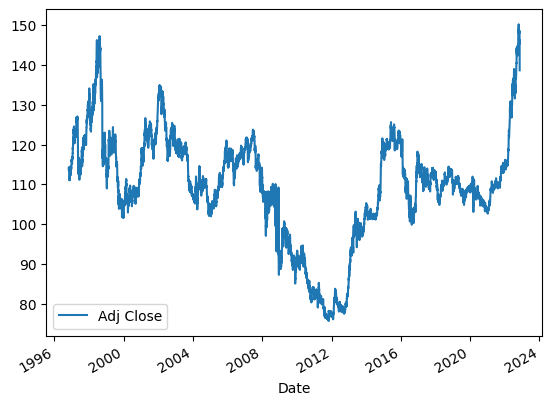

In [71]:
# Plot the data
ticker_data.index = pd.to_datetime(ticker_data.index) # Convert the index to a datetime value
ticker_data.plot.line(y="Adj Close", use_index=True)

### Converting Data
To use NEAT, we need to convert the ticker data and optimize the parameters we pass to it. We need to show the algorithm some trends in the data so it is able to learn patterns

In [72]:
import pandas_ta as ta # We use pandas_ta to see trends in the ticker data
from sklearn.preprocessing import MinMaxScaler # Used to scale values between 0 and 1

# Insert new rows to the ticker data using pandas_ta
"""
    RSI tells us overbought / oversold conditions in the market
    EMAF tells us the exponential moving average

    The rolling averages will tell us whether the market has gone up or down
"""
horizons: list[int] = [2, 5, 60, 250, 1000] # The mean closing prices we'll use; 2days, 5days, ... 

def convert_dataframe(dataframe) -> pd.DataFrame:
    dataframe.reset_index(inplace=True) # Reset index of dataframe, this gives us an index of integers instead of Dates
    dataframe.drop(["Volume", "Close", "Date", "High", "Low"], axis=1, inplace=True) # Drop unneeded columns


    # Create new rows to see target value for tomorrow; this is used to train the model
    dataframe["Target"] = dataframe["Adj Close"] - dataframe["Open"] # Calculate whether the value increased or decreased
    dataframe["Target"] = dataframe["Target"].shift(-1) # Shift the target by - 1 so we know tomorrow's target

    dataframe["TargetClass"] = (dataframe["Target"] > 0).astype(int) # Classify buy/sell

    dataframe["RSI"] = ta.rsi(dataframe["Adj Close"], length=15) 
    dataframe["EMAM"] = ta.ema(dataframe["Adj Close"], length=100)
    dataframe["EMAF"] = ta.ema(dataframe["Adj Close"], length=20) 
    dataframe["EMAS"] = ta.ema(dataframe["Adj Close"], length=150)

    for horizon in horizons: # Loop through these closing prices and add them as a column 
        rolling_averages: pd.DataFrame = dataframe.rolling(horizon).mean() 

        # Add to the dataframe
        ratio_column: str = f"Close Ratio {horizon}"
        dataframe[ratio_column] = dataframe["Adj Close"] / rolling_averages["Adj Close"]

        trend_column: str = f"Trend {horizon}"
        dataframe[trend_column] = dataframe.shift(1).rolling(horizon).sum()["TargetClass"]


    # Drop Missing Values
    dataframe.dropna(inplace=True)
    dataframe.reset_index(inplace=True) # Reset index again because we dropped null values
    dataframe.drop(["index"], axis=1, inplace=True)

    scaled_data: pd.DataFrame = dataframe.copy(deep=True) # Deep Copy 
    scaled_data.drop(["Open", "Target", "TargetClass"], axis=1, inplace=True) # Only give the model values it will know in the real world
    # Optimize data range between 0 to 1 for the model
    scaled_data = MinMaxScaler(feature_range=(0,1)).fit_transform(scaled_data)

    return scaled_data



scaled_data = convert_dataframe(ticker_data) # Convert dataframe with important values

ticker_data

,Open,Adj Close,Target,TargetClass,RSI,EMAM,EMAF,EMAS,Close Ratio 2,Trend 2,Close Ratio 5,Trend 5,Close Ratio 60,Trend 60,Close Ratio 250,Trend 250,Close Ratio 1000,Trend 1000
0,106.889999,106.949997,-0.419998,0,49.301083,107.222479,106.878933,107.345713,1.000281,1.0,0.998469,3.0,0.994575,28.0,1.005433,123.0,0.900874,504.0
1,107.019997,106.599998,0.089996,1,46.260185,107.210152,106.852368,107.335836,0.998361,1.0,0.996057,2.0,0.991133,27.0,1.002170,122.0,0.897978,504.0
2,106.550003,106.639999,1.540001,1,46.663032,107.198862,106.832142,107.326620,1.000188,1.0,0.997867,2.0,0.991285,28.0,1.002567,123.0,0.898370,504.0
3,106.459999,108.000000,-0.279999,0,58.103726,107.214726,106.943367,107.335539,1.006336,2.0,1.009195,3.0,1.003618,28.0,1.015335,123.0,0.909875,504.0
4,107.930000,107.650002,-0.290001,0,54.859112,107.223346,107.010665,107.339704,0.998377,1.0,1.004498,3.0,1.000076,28.0,1.012011,123.0,0.906974,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5744,148.393005,148.393005,0.000000,0,58.506755,140.449909,147.339601,136.825016,1.001691,0.0,1.001642,0.0,1.035956,0.0,1.155986,38.0,1.309458,403.0
5745,146.841003,146.841003,0.000000,0,51.110192,140.576465,147.292116,136.957678,0.994743,0.0,0.992467,0.0,1.023507,0.0,1.142731,38.0,1.295316,403.0
5746,146.623993,146.623993,0.000000,0,50.160168,140.696218,147.228485,137.085709,0.999261,0.0,0.993839,0.0,1.020396,0.0,1.139913,38.0,1.292967,402.0
5747,145.294998,145.294998,0.000000,0,44.707453,140.787283,147.044343,137.194441,0.995447,0.0,0.988341,0.0,1.009857,0.0,1.128523,38.0,1.280834,402.0


### Plotting the Statistics
To plot the statistics of the neural network, matplotlib is used while the neat module gives us most of the info needed to create the charts.

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the statistics
def plot_statistics(stats):
    generation = range(len(stats.most_fit_genomes))
    best_fitness = [c.fitness for c in stats.most_fit_genomes]
    avg_fitness = np.array(stats.get_fitness_mean())
    stdev_fitness = np.array(stats.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 std")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 std")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Learning Curve of population")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

### Training The Model

In [74]:
%matplotlib inline
import math
import multiprocessing
import neat
import pickle
import random
import time
import visualize


config_path: str = "../assets/neat-config.txt"
highest_index_reached = 0

class Forex:
    def __init__(self):
        self.bought_for = 0
        self.held_for = 0
        self.bought = 0
    
    def buy(self, bought_for):
        if self.bought != 1:
            self.bought_for = bought_for
            self.bought = 1


    def check_value(self, current_value):
        if self.bought == 1:
            return current_value - self.bought_for
        else:
            return 0


    def hold(self):
        self.held_for += 1


    def sell(self, sold_for):
        to_return = sold_for - self.bought_for
        
        if self.bought_for == 0:
            return 0
        else:
            self.bought_for = 0 # Reset trade
            self.bought = 0

        return to_return


def evaluate_genomes(genomes, config) -> None:
    networks: list = []
    genome_list: list = []
    money_list = []
    # money_list: list = []

    index: int = random.randint(0, len(ticker_data) - 1000) # Make model learn from random index each iteration ?
    iteration = 0
    
    for genome_id, genome in genomes:
        genome.fitness = 0 # Start every genome with a fitness of 0
        # Append the net to the nets list
        networks.append(neat.nn.FeedForwardNetwork.create(genome, config))  # Neat.NeuralNetwork.FeedForwardNetwork
        genome_list.append(genome) # append each genome to the genome list, when genome list is empty go to the next generation
        money_list.append(Forex())

    while index < len(ticker_data):
        process_data = scaled_data[index] # MinMaxed data
        target = ticker_data.T[index][2] # Difference between today's close and tomorrows close
        target_c = ticker_data.T[index][3] # Positive/ Negative, tells whether we should've bought or sold
        current_close = ticker_data.T[index][1]

       # Loop through list of people
        for x, model in enumerate(genome_list):
            money = money_list[x]
            # Make prediction
            prediction = networks[x].activate(np.append(process_data, money.bought))
            decision = prediction.index(max(prediction))
            

            # print(decision_list[decision], target)

            # Main Logic
            match decision:
                case 0: # Hold trade
                    money.hold()
                    if money.check_value(current_close) > 0:
                        model.fitness += 0.0001
                    else:
                        model.fitness -= 0.0001
                    # if target == 0 and target_c == 0: # Validate decision
                    #     # model.fitness += 1 # Reward the model
                    #     pass

                    # elif target > 0 and target_c == 1: # Could have cashed out
                    #     model.fitness -= target
                        
                    # elif target < 0: # Lost a hold trade
                    #     model.fitness -= (-target)+1 # Punish the model

                    # else:
                    #     model.fitness -= 1

                    pass

                case 1: # Buy
                    if money.bought_for == 0:
                        money.buy(current_close)
                        model.fitness += 0.0001
                    else:
                        model.fitness -= 0.0001
                    # else:
                    #     model.fitness -= 0.05
                    # if target > 0:
                    #     # print("WON BY ", target)
                    #     # model.fitness += target
                    # else:
                    #     model.fitness += target

                case 2: # Sell
                    profit = money.sell(current_close)


                    if profit != 0:
                        print(f"MADE PROFIT[{money.held_for}]: {profit:.4f} \t\t{'+'*int(profit) if (profit > 0) else '-'*(-int(profit))}")
                        model.fitness += profit
                    else:
                        model.fitness -= 0.0001
                    # if (target < 0 and target_c != 0):
                    #     model.fitness += target
                    #     # money_list[x] = money_list[x] + money_list[x]*(ticker_data.T[index+1][1]/-target)/
                    #     # print(f"MONEY FOR {x}> {money_list[x]}")
                    # elif target > 0:
                    #     model.fitness -= target

            if model.fitness < 0:
                networks.pop(x) # Remove model from this generation
                genome_list.pop(x)
            

        # Go to the next row if there are no people left
        if len(genome_list) > 0:
            index += 1 # Go to next day
            iteration += 1
            global highest_index_reached
            if iteration > highest_index_reached:
                highest_index_reached = iteration
        else:
            # print(f"Went up by {highest_index_reached}")
            break




def train_model(checkpoint=None, generations=1000) -> None:
    # Set neat config
    config = neat.Config(
        neat.DefaultGenome, neat.DefaultReproduction, 
        neat.DefaultSpeciesSet, neat.DefaultStagnation,
        config_path
    )

    # Initialize Population Variable
    population: neat.Population;

    # Check if checkpoint parameter was passed
    if checkpoint is not None:
        try:
            population = neat.Checkpointer.restore_checkpoint(f"neat-checkpoint-{checkpoint}")
        except FileNotFoundError:
            print(f"File \"neat-checkpoint-{checkpoint}\" not found, starting from generation 0")
            population = neat.Population(config=config)
    else:
        population = neat.Population(config=config)


    # Add reporters (Testing purposes)
    networkStatistics = neat.StatisticsReporter()
    population.add_reporter(neat.Checkpointer(2000))
    population.add_reporter(neat.StdOutReporter(True))
    population.add_reporter(networkStatistics)

    # Run the population
    best_node = population.run(evaluate_genomes, generations)

    plot_statistics(networkStatistics) # Plot the statistics after we are finished 1000 generations

    # Save the best node in a pickle file
    with open("../assets/best.pickle", "wb") as file:
        pickle.dump(best_node, file)
    
    
# load_best(config_path)
train_model(generations=100)


 ****** Running generation 0 ****** 

MADE PROFIT[0]: -1.3110 		-
MADE PROFIT[1]: -0.1500 		
MADE PROFIT[1]: -0.1500 		
Population's average fitness: -0.03231 stdev: 0.18500
Best fitness: -0.00010 - size: (9, 162) - species 7 - id 13
Average adjusted fitness: 0.993
Mean genetic distance 3.012, standard deviation 0.511
Population of 50 members in 15 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     3     -0.0    1.000     0
     2    0     3     -0.0    1.000     0
     3    0     7     -0.0    0.888     0
     4    0     2     -0.0    1.000     0
     5    0     3     -0.0    1.000     0
     6    0     3     -0.0    1.000     0
     7    0     2     -0.0    1.000     0
     8    0     4     -0.0    1.000     0
     9    0     6     -0.0    1.000     0
    10    0     2     -0.0    1.000     0
    11    0     3     -0.0    1.000     0
    12    0     5     -0.0    1.000     0
    13    0     3     -0.0    1.000     0
    14   

KeyboardInterrupt: 

### Testing

In [ ]:
decision_list = {0: "Hold", 1: "Buy", 2: "Sell"}

# Test a specific genome
def test_genome(genome=None, process_data=None) -> int:
    # Error catching
    if process_data is None: # Catch errors if the process data isnt passed
        raise Exception("Error, process data is needed.") 


    if genome is None: # If genome isn't passed, use the best.pickle
        try:  # Catch any errors when trying to open the best.pickle file
            with open("../assets/best.pickle", "rb") as f:
                genome = pickle.load(f)
        except FileNotFoundError:
            print("(best.pickle) File not found, please load the file and try again")
            return -1
        except:
            print("Unknown error occured")
            return -1

    # Declare config 
    config = neat.Config(
        neat.DefaultGenome, neat.DefaultReproduction, 
        neat.DefaultSpeciesSet, neat.DefaultStagnation,
        config_path
    )

    population = neat.Population(config) # Start a new population with the config
    network: neat.nn.FeedForwardNetwork = neat.nn.FeedForwardNetwork.create(genome=genome, config=config) # Get the network passed and feed it this genome


    # Predictions
    prediction: list[float] = network.activate(process_data)
    decision: float = prediction.index(max(prediction))

    print(f"PREDICTION: {prediction} - {decision_list[decision]}")



    return decision


test_data = pd.read_csv(f"{assets_path}/INR=X.csv", index_col=0) # Use microsoft as test data
index = 222

test_scaled = convert_dataframe(test_data) # Convert dataframe so we can send it to the model

for i in range(len(test_data)):
    genome_decision = test_genome(process_data=np.append(test_scaled[i], 0)) # Transpose the test data and send the second last index
    print(f"i: [{i}] - {decision_list[genome_decision]}")

# print(f"Genome's decision: {genome_decision}")
# print(f"{len(test_scaled)} : {len(test_data)}")
print(f"{test_data.T[index]} : {test_scaled[index]}")
# print(test_data)
# print(f"Table values: {test_data[-200:-199]}")
# print(pd.DataFrame(test_scaled)[-200:-198])
test_data[1000:2000]

PREDICTION: [9.425460261952047, 5.185718863141403, 6.328857388870424] - Hold
i: [0] - Hold
PREDICTION: [9.416974734392104, 5.161266703317743, 6.326636476827167] - Hold
i: [1] - Hold
PREDICTION: [9.69572354067309, 5.080656557827419, 6.207556535253353] - Hold
i: [2] - Hold
PREDICTION: [9.444387712675512, 5.110133049603746, 6.2490336844680066] - Hold
i: [3] - Hold
PREDICTION: [9.236140003180354, 5.165602279054266, 6.30359862331828] - Hold
i: [4] - Hold
PREDICTION: [9.47488333754521, 5.107848162031211, 6.219833816078892] - Hold
i: [5] - Hold
PREDICTION: [9.691718134478341, 5.212642109122026, 6.365494083383972] - Hold
i: [6] - Hold
PREDICTION: [9.73290826299718, 5.177434231178679, 6.289525737813031] - Hold
i: [7] - Hold
PREDICTION: [9.418411721069315, 5.390516077956983, 6.534038577525613] - Hold
i: [8] - Hold
PREDICTION: [9.214566857164954, 5.45259371401931, 6.566965448956803] - Hold
i: [9] - Hold
PREDICTION: [9.508038755692224, 5.384245489364487, 6.413561267578663] - Hold
i: [10] - Hold
PR

KeyboardInterrupt: 